<div style="position: relative;"> 
  <h1 style="position: relative">Leasing Price Predictor</h1>

  <img src="components/wu-logo.png" alt="Logo" width="150" height="auto" style="position: absolute; top: 0; right: 0;">

  created by:

    Tobias Ponesch
    Sina Haghgoo
    Finnian John Dempsey
    Vinicius Wolff
    Adrian Lehrner

  In cooperation with:
  
  <img src="components/zeb-logo.png" alt="ZEB" width="200" height="auto">

  This work draws inspiration from the master thesis conducted by Thomas Dornigg. To delve deeper into Dornigg's thesis, please refer to the following link:

  https://nbviewer.org/github/ThomasD96/University_Repo/blob/master/Nova_SBE/Master_thesis/Credit_Risk_Modeling.ipynb
</div>

## Table of Contents

1. [Import Libraries](#import-libraries)
2. [Computational effort](#computational-effort)
3. [Dataset import](#dataset-import)
4. [Basic Preprocessing](#basic-preprocessing)
5. [Explanatory Data Analysis](#explanatory-analysis)
   - 5.1 [The Target variable](#target-variable)
   - 5.2 [Numerical Features](#numerical-features)
     - 5.2.1 [Skewness of numerical variables](#skewness)
   - 5.3 [Categorical Features](#categorical-features)
   - 5.4 [Target variable vs. categorical features](#target-cat)
   - 5.5 [Heatmap (Correlations)](#heatmap)
     - 5.5.1 [Dropping kilowatts](#drop-kilowatts)
6. [Preprocessing and Feature Engineering](#preprocessing)
   - 6.1 [Missing Values](#missing-values)
   - 6.2 [Cardinality of non-numeric features](#cardinality)
   - 6.3 [Problems with splitting -- STILL OPEN](#splitting-problem)
   - 6.4 [Out of Sample split](#osample-split)
   - 6.5 [Train and Test split](#train-test-split)
   - 6.6 [Transformer Pipelines](#transformer-pipelines)
7. [Machine Learning Modeling](#machine-learning-modeling)
   - 7.1 [Choosing appropriate metric & customization approach](#metric)
   - 7.2 [Decision Tree](#decision-tree)
   - 7.3 [Random Forest](#random-forest)
   - 7.4 [K-nearest neighbor](#k-neighbors)
   - 7.5 [XGB](#xgb)
   - 7.6 [Support-Vector-Machines (SVM)](#svm)
8. [Test Data Performance](#test-performance)
   - 8.1 [Metrics comparison](#test-metrics-comparison)
   - 8.2 [Predicted vs actual plots](#test-predicted-actual)
   - 8.3 [Histogram of residuals](#test-histograms)
9. [Out of sample performance](#osample-performance)
   - 9.1 [Metrics comparison](#osample-metrics-comparison)
   - 9.2 [Predicted vs actual plots](#osample-predicted-actual)
   - 9.3 [Histogram of residuals](#osample-histograms)
10. [Feature Importance Analysis](#feature-importance)
    - 10.1 [Decision tree feature importance](#importance-decisiontree)
    - 10.2 [Random forest feature importance](#importance-randomForest)
    - 10.3 [XGB feature importance](#importance-xgb)
11. [Light models (reduced complexity)](#light-models)
    - 11.1 [Best two performing full models](#light-best)
        - 11.1.1 [Random Forest](#light-forest)
        - 11.1.2 [XGB](#light-xgb)
    - 11.2 [Performance full vs light models](#light-comparison)
        - 11.2.1 [Performance full vs light models](#light-comparison-PvA)
12. [Safe models](#safe-models)
13. [Debugging library versions](#debugging-libraries)


## 1 Import Libraries<a id="import-libraries"></a>

In [1]:
import pandas as pd
import numpy as np

#Sklearn Preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Sklearn model builder:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#XGB model
from xgboost import XGBRegressor

#Sklearn metrics:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

#Model evaluation
import shap
from sklearn.metrics import PredictionErrorDisplay

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler


#from sklearn.preprocessing import OneHotEncoder

#Other helper libraries
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from joblib import dump, load
import multiprocessing
import psutil
import threading
import time
import os

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(al

## 2 Computational effort<a id="computational-effort"></a>

In [2]:
# ---- EXECUTE THIS CELL ----
calc_models = input("If you want to compute the models, enter \"Yes\". Otherwise type \"No\", and the models will be loaded:")
calc_models = calc_models.lower()
allowed=["yes", "no"]
while calc_models not in allowed:
    print("Invalid input. Please try again.")
    calc_models = input("If you want to compute the models, enter \"Yes\". If you want to load the existing models, enter \"No\":")
    calc_models.lower()

if calc_models == "yes":
    compute = True
else:
    compute = False    


if compute:
    allowed_values = ["ludicrous", "high", "medium", "low"]

    comp_effort = input("Enter your computational performance (High, Medium, or Low): ")
    comp_effort = comp_effort.lower()

    while comp_effort not in allowed_values:
        print("Invalid input. Please try again.")
        comp_effort = input("Enter your computational performance (Ludicrous, High, Medium, or Low): ")
        comp_effort = comp_effort.lower()

    # The user input is valid
    print("Your computational performance:", comp_effort)

    #To ensure machine usability while executing models, we define usable cores
    available_cores = multiprocessing.cpu_count()



Your computational performance: low


## 3 Dataset import <a id="dataset-import"></a>

In [3]:
datafolder = "data"
modelfolder = "models/current"

In [4]:
df = pd.read_excel(f'{datafolder}/dataset_2023.xlsx')
df = df.drop('Unnamed: 0', axis = 1)
df

,brand_name,model_name,milage,first_registration,duration,gear,monthly_fee,emission_value,consumption,horsepower,kilowatts,fuel_type
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [5]:
#Enter the actual column names
brand = "brand_name"
model = "model_name"
milage = "milage"
registration = "first_registration"
duration = "duration"
gear = "gear"
fee = "monthly_fee"
emission = "emission_value"
consumption = "consumption"
horsepower = "horsepower"
kilowatts = "kilowatts"
fuel = "fuel_type"

rename_columns = {
    brand:"brand",
    model:"model",
    milage:"milage",
    registration:"registration",
    duration:"duration",
    gear:"gear",
    fee:"fee",
    emission:"emission",
    consumption:"consumption",
    horsepower:"horsepower",
    kilowatts:"kilowatts",
    fuel:"fuel"
}

df = df.rename(columns=rename_columns)
df

,brand,model,milage,registration,duration,gear,fee,emission,consumption,horsepower,kilowatts,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [6]:
SEED = 2023
TARGET_name = "fee"
FEATURE_names = df.drop(TARGET_name, axis=1).columns

## 4 Basic Preprocessing<a id="basic-preprocessing"></a>

In [7]:
class CalculateAge(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass
    
    def transform(self, X, y=None):
        print(self.columns)
        def calculate_age(registration_date):
            if registration_date == "Neuwagen":
                return 0
            else:
                today = datetime.now()
                date = datetime.strptime(registration_date, "%m/%Y")
                delta = relativedelta(today, date)
                return (delta.years * 12) + delta.months
        Xc = X.copy()
        if self.columns:
            columns = self.columns
        else:
            columns = Xc.columns
        Xc[columns[0]] = Xc[columns[0]].replace(["","nan"], np.nan)
        Xc[columns[0]] = Xc[columns[0]].apply(calculate_age)
        return Xc

class RemoveUnits(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def extractFloats(input):
            try:
                input = input.split(" ")[0]
                f = float(input.replace('.','').replace(',','.'))
                return(f)
            except AttributeError:
                return input        
        
        X_=X.copy()
        columns = X.columns
        X_[columns] = X_[columns].apply(lambda col: col.replace(["","nan"], np.nan))
        X_[columns] = X_[columns].apply(lambda col: col.apply(extractFloats))
        return X_
        
    def get_feature_names_out(self):
        pass
       

In [8]:
units = ["milage", "duration", "fee", "emission", "consumption", "horsepower", "kilowatts"]

basicpreprocessor = ColumnTransformer(
    transformers=[
        ('age', CalculateAge(),["registration"]),
        ('unit', RemoveUnits(),units)
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

df = basicpreprocessor.fit_transform(df)
df.head()

None


,registration,milage,duration,fee,emission,consumption,horsepower,kilowatts,brand,model,gear,fuel
0,2,201.0,48.0,574.01,119.0,5.0,150.0,110.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,2,201.0,48.0,382.58,131.0,6.0,95.0,70.0,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,7,15000.0,48.0,239.62,120.0,5.0,80.0,59.0,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,4,1.0,48.0,309.11,127.0,6.0,80.0,59.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,41,105301.0,48.0,587.75,138.0,5.0,190.0,140.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel


In [9]:
basicpreprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('age', CalculateAge(), ['registration']),
                                ('unit', RemoveUnits(),
                                 ['milage', 'duration', 'fee', 'emission',
                                  'consumption', 'horsepower', 'kilowatts'])],
                  verbose_feature_names_out=False)

In [10]:
TARGET = pd.DataFrame(df["fee"])
num_FEATURES = df[df.select_dtypes(include=['float64', 'int64']).columns].drop("fee", axis=1)
cat_FEATURES = df[df.select_dtypes(exclude=['float64', 'int64']).columns]

## 5 Explanatory Data Analysis<a id="explanatory-analysis"></a>

### 5.1 The Traget variable <a id="target-variable"></a>

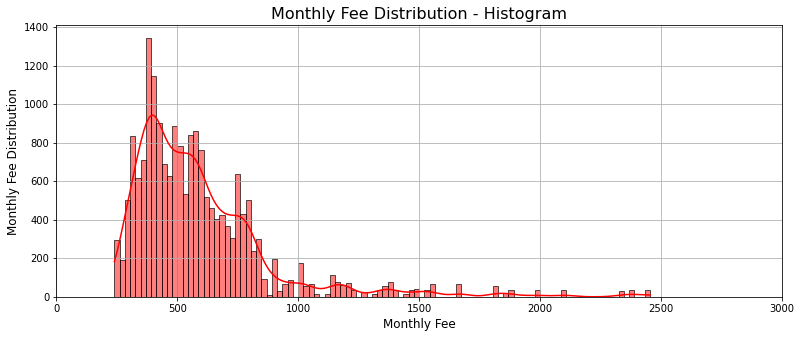

In [11]:
# Histogram
hist_color = 'red'
title_font_size = 16
label_font_size = 12
plt.figure(figsize=(13,5))
sns.histplot(TARGET['fee'], kde=True, color=hist_color)
plt.title('Monthly Fee Distribution - Histogram', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.xticks(ticks=plt.xticks()[0][::1])  
plt.ylabel('Monthly Fee Distribution', fontsize=label_font_size)
plt.grid(True)
plt.show()

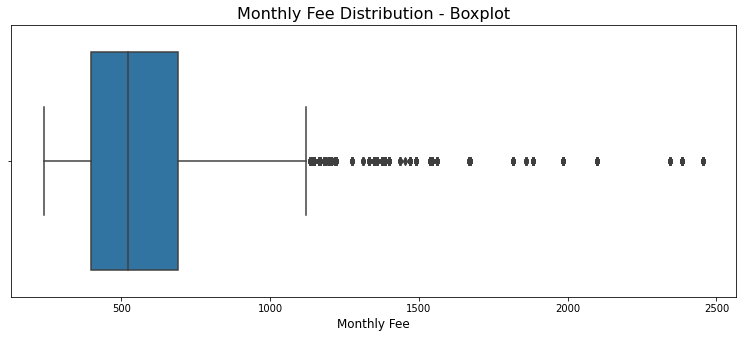

In [12]:
# Boxplot
plt.figure(figsize=(13,5))
sns.boxplot(x=df['fee'])
plt.title('Monthly Fee Distribution - Boxplot', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.show()

### 5.2 Numerical Features <a id="numerical-features"></a>

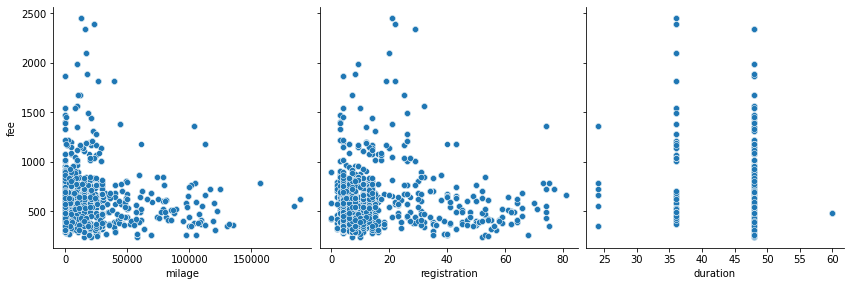

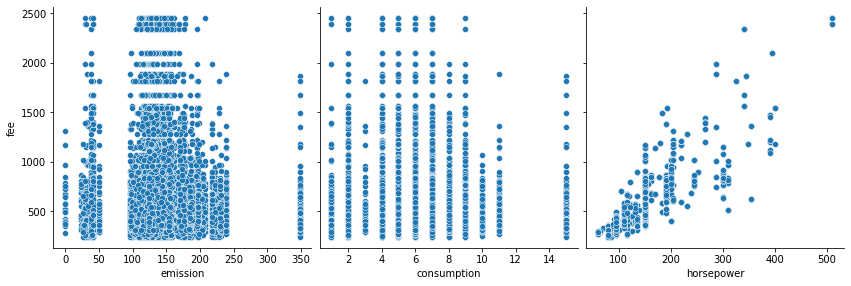

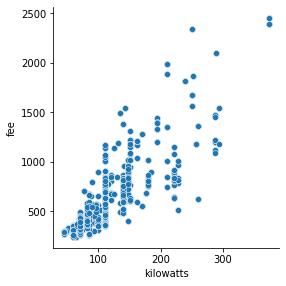

In [13]:
def pp(x,y,z):
    sns.pairplot(df, x_vars=[x,y,z], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('milage', 'registration', 'duration')
pp('emission', 'consumption', 'horsepower')

def pp(x):
    sns.pairplot(df, x_vars=[x], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('kilowatts')

#### 5.2.1 Skewness of numerical variables <a id="skewness"></a>

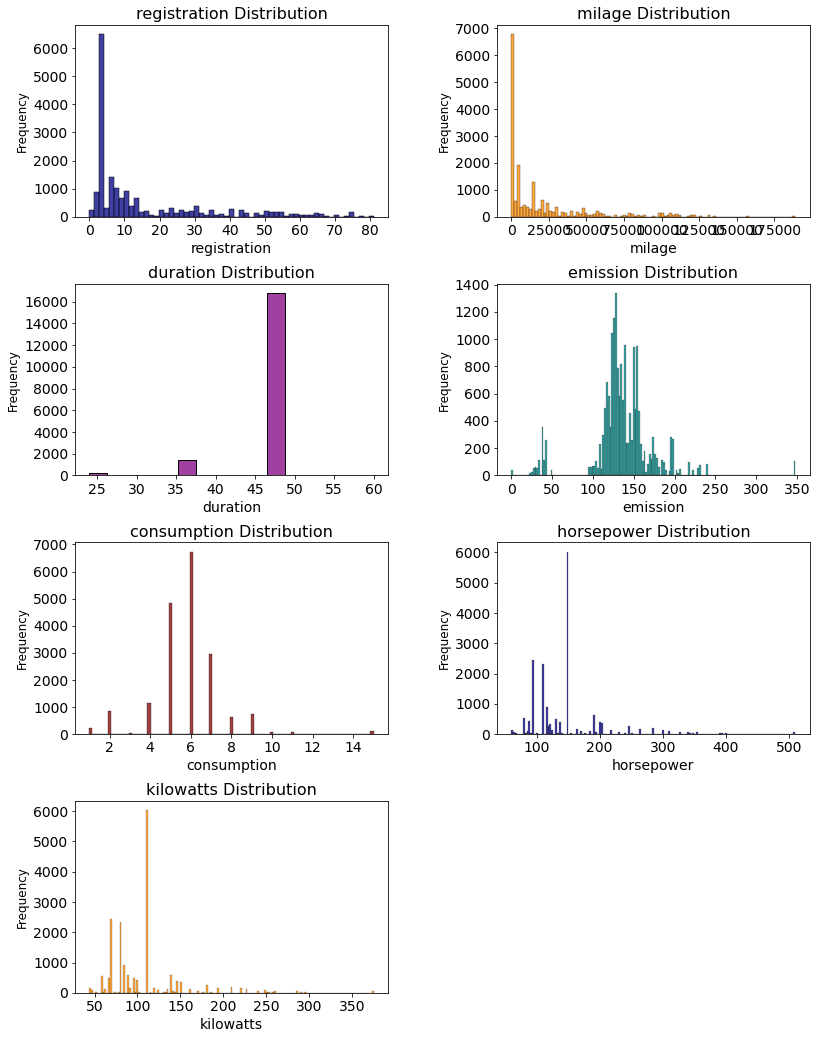

In [14]:
num_FEATURES_hist = num_FEATURES.dropna()

plt.figure(figsize=(12,16))

colors = ['navy', 'darkorange', 'purple', 'teal', 'maroon']

for i, col in enumerate(num_FEATURES_hist.columns):
    idx = int('42' + str(i+1))
    plt.subplot(idx)
    sns.histplot(num_FEATURES_hist[col], color=colors[i % len(colors)])
    plt.title(col+' Distribution', fontsize=16)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(col, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()


### 5.3 Categporical Features <a id="categorical-features"></a>

In [15]:
cat_FEATURES

,brand,model,gear,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,Automatik,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
19056,Volkswagen,Polo VW,Manuelle Schaltung,Benzin


Text(0.5, 1.0, 'Gear Frequencies')

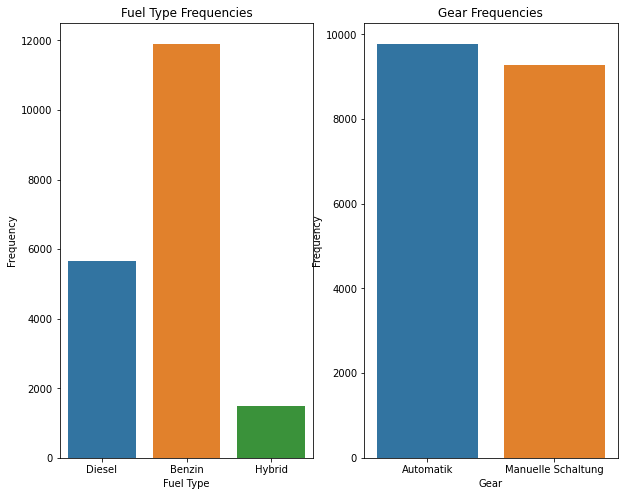

In [16]:
# Create subplots for each categorical variable

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 8))

# Fuel type barplot
sns.countplot(x='fuel', data=cat_FEATURES, ax=axs[0])
axs[0].set_xlabel('Fuel Type')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Fuel Type Frequencies')

# Gear barplot
sns.countplot(x='gear', data=cat_FEATURES, ax=axs[1])
axs[1].set_xlabel('Gear')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Gear Frequencies')

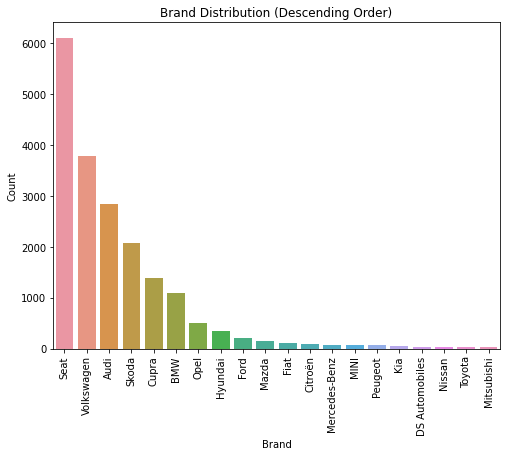

In [17]:
# Distribution of brands
brand_counts = df['brand'].value_counts()

brand_counts = brand_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='brand', order=brand_counts.index)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Brand Distribution (Descending Order)')
plt.xticks(rotation=90)
plt.show()




### 5.4 Target variable vs. categorical features <a id="target-cat"></a>

<Figure size 1800x432 with 0 Axes>

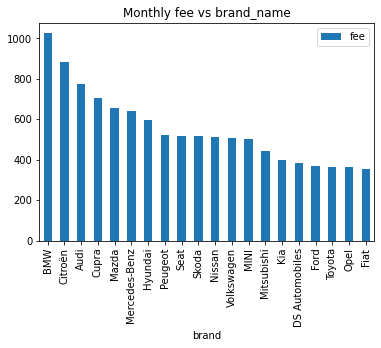

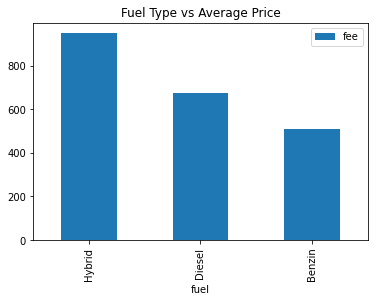

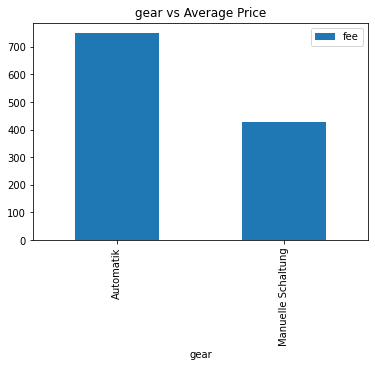

In [18]:
plt.figure(figsize=(25, 6))

df_brand = pd.DataFrame(df.groupby(['brand'])['fee'].mean().sort_values(ascending = False))
df_brand.plot.bar()
plt.title('Monthly fee vs brand_name')
plt.show()

df_fueltype = pd.DataFrame(df.groupby(['fuel'])['fee'].mean().sort_values(ascending = False))
df_fueltype.plot.bar()
plt.title('Fuel Type vs Average Price')
plt.show()

df_gear = pd.DataFrame(df.groupby(['gear'])['fee'].mean().sort_values(ascending = False))
df_gear.plot.bar()
plt.title('gear vs Average Price')
plt.show()

### 5.5 Heatmap (Correlations) <a id="heatmap"></a>

In [19]:
num_FEATURES

,registration,milage,duration,emission,consumption,horsepower,kilowatts
0,2,201.0,48.0,119.0,5.0,150.0,110.0
1,2,201.0,48.0,131.0,6.0,95.0,70.0
2,7,15000.0,48.0,120.0,5.0,80.0,59.0
3,4,1.0,48.0,127.0,6.0,80.0,59.0
4,41,105301.0,48.0,138.0,5.0,190.0,140.0
...,...,...,...,...,...,...,...
19053,4,201.0,48.0,146.0,6.0,150.0,110.0
19054,2,201.0,48.0,187.0,8.0,150.0,110.0
19055,41,105301.0,48.0,143.0,6.0,190.0,140.0
19056,35,18903.0,48.0,40.0,2.0,80.0,59.0


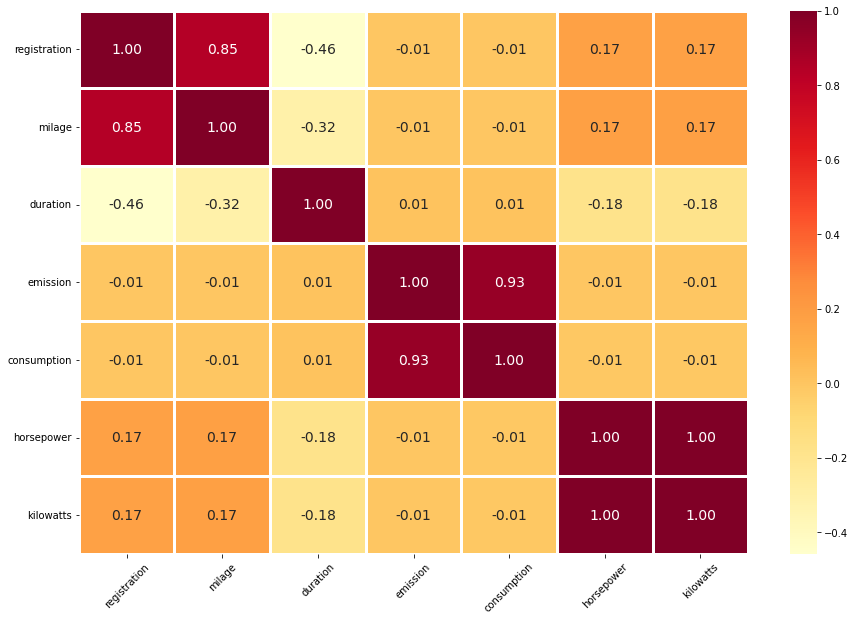

In [20]:
num_corr = num_FEATURES.corr()

# setting figure size
plt.figure(figsize=(15, 10))

# heatmap
sns.heatmap(num_corr, annot=True, linewidths=1.01, fmt=".2f", annot_kws={"size": 14}, linecolor='white', cmap="YlOrRd")

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


#### 5.5.1 Dropping kilowatts <a id="drop-kilowatts"></a>

In [21]:
df = df.drop('kilowatts', axis = 1)
num_FEATURES = num_FEATURES.drop("kilowatts", axis=1)
FEATURE_names = FEATURE_names.drop("kilowatts")

## 6. Preprocessing and Feature Engineering <a id="preprocessing"></a>

### 6.1 Missing Values<a id="missing-values"></a>


In [22]:
missing_values = df.isnull().sum()

print("Summary of Missing Values:")
print(missing_values)

Summary of Missing Values:
registration      0
milage            0
duration          0
fee               0
emission        612
consumption     612
horsepower        0
brand             0
model             0
gear              0
fuel              0
dtype: int64


### 6.2 Cardinality of non-numeric features<a id="cardinality"></a>

In [23]:
unique_counts = cat_FEATURES.nunique()
print(unique_counts)

brand     20
model    346
gear       2
fuel       3
dtype: int64


### 6.3 Problems with splitting -- STILL OPEN <a id="splitting-problem"></a>

When splitting the dataset by using "train_test_split" we need to use stratification so that one-hot encoding works.
This creates the problem, that entries of the model column, that exist only once OR Twice can not be splitted using stratify. We have three possible approaches:
- drop once or twice appearing single entries of "model"
- duplicate or tripple once or twice appreaing entries of "model"
- create combined category for those models
- **use a custom splitting algorithm**

for now we desided to drop those entries -> Do other approach later!!!!

In [24]:
old_shape = df.shape[0]

In [25]:
few_instances_model = df.groupby("model").filter(lambda x: len(x) < 3)["model"].unique()
df=df[~df["model"].isin(few_instances_model)]
print("Models dropped:", old_shape-df.shape[0])

Models dropped: 19


In [26]:
df

,registration,milage,duration,fee,emission,consumption,horsepower,brand,model,gear,fuel
0,2,201.0,48.0,574.01,119.0,5.0,150.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,2,201.0,48.0,382.58,131.0,6.0,95.0,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,7,15000.0,48.0,239.62,120.0,5.0,80.0,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,4,1.0,48.0,309.11,127.0,6.0,80.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,41,105301.0,48.0,587.75,138.0,5.0,190.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
...,...,...,...,...,...,...,...,...,...,...,...
19053,4,201.0,48.0,692.03,146.0,6.0,150.0,Seat,Ateca FR 2.0 TDI DSG 4Drive,Automatik,Diesel
19054,2,201.0,48.0,574.01,187.0,8.0,150.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
19055,41,105301.0,48.0,587.75,143.0,6.0,190.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
19056,35,18903.0,48.0,256.33,40.0,2.0,80.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin


In [27]:
df.to_csv("data/preprocessed.csv", index=False)

### 6.4 Out of Sample split <a id="osample-split"></a>

In [28]:
df_sample, df_osample = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df[["model"]])

In [29]:
print("Size of the sample data:",df_sample.shape, "with a mean of: ",df_sample["fee"].mean(),
    "\nSize of out of sample data:",df_osample.shape, "with a mean of: ",df_osample["fee"].mean())

Size of the sample data: (16183, 11) with a mean of:  593.0066569857258 
Size of out of sample data: (2856, 11) with a mean of:  592.3941316526611


### 6.5 Train and Test slpit<a id="train-test-split"></a>

In [30]:
X_sample = df_sample.drop(TARGET_name,axis=1)
Y_sample = df_sample[TARGET_name]

X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.25, random_state=SEED, stratify=X_sample[["model"]])
print("Size of the train data:",X_train.shape,"with a mean fee of:",y_train.mean())
print("Size of the test data:",X_train.shape,"with a mean fee of:",y_test.mean())

Size of the train data: (12137, 10) with a mean fee of: 593.1457435939689
Size of the test data: (12137, 10) with a mean fee of: 592.5894315373208


### 6.6 Transformer Pipelines<a id="transformer-pipelines"></a>

In [31]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES.columns

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error', sparse_output=False, drop = 'first'))])

preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

preprocessor.fit(X_train)

cat_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
columns_pipeline = np.append(cat_columns, numeric_features)

## 7 Machine Learning Modeling<a id="machine-learning-modeling"></a>

### 7.1 Choosing appropriate metric & customization approach <a id="metric"></a>

For evaluation we chose a number of measurements:
- MSE: Mean-Square-Error
- RMSE: Root-Mean-Square-Error (for easier interpretation)
- R-squared (R²)
- Adjusted R-squared
- MAPE: Mean Absolute Percentage Error
- EVS: Explained variance score

#### Monitoring helper function

In [33]:
### CAVE: This function is used to print your CPU and memory usage.
### it's called in model building cells and assigned A SEPERATE THREAT.
### If you terminate a cell, while this threat is running, it will NOT TERMINATE this threat!!!
def monitor_system():
    while monitoring:
        cpu_usage = psutil.cpu_percent()
        memory_usage = psutil.virtual_memory()
        print(f"CPU usage: {cpu_usage}%")
        print(f"Memory usage: {memory_usage}%")

        time.sleep(10)  # Sleep

In [34]:
##### TO TERMINATE SUCH A THREAT EXECUTE ####
# monitoring = False
# monitoring_thread.join()

In [35]:
if compute:
    if comp_effort == "low":
        crossvals = 3
        iterations = 10
        cores = available_cores
    elif comp_effort =="medium":
        crossvals = 5
        iterations = 20
        cores = available_cores-2
    elif comp_effort == "high":
        crossvals = 5
        iterations = 30
        cores = available_cores-2
    else:
        crossvals = 7
        iterations = 50
        cores = available_cores-2


def evaluate(model, X, Y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(Y, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    evs = explained_variance_score(Y, y_pred)
    mapr = mean_absolute_percentage_error(Y, y_pred)

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "EVS": evs,
        "MAPE": mapr
    }
    return (metrics)

# Scoring dictionary
scoring1 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}
scoring2 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}
scoring3 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring4 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring = scoring4

### 7.2 Decision Tree <a id="decision-tree"></a>

In [36]:
# Define the parameter distribution
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    param_dist = {
        #'regressor__max_depth': randint(1, 10), # increasing depth always increases score -> overfitting
        'regressor__min_samples_split': [10, 20, 30, 40 ,50],
        'regressor__min_samples_leaf': [2, 4, 8, 10, 15, 20 ,30],
        'regressor__ccp_alpha': uniform(0, 0.05) # search for best ccp_alpha
    }

    # Create a new pipeline with the decision tree regression model
    decisionTree_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", DecisionTreeRegressor())
    ])

    # Perform randomized search with cross-validation
    decisionTree_randomized_search = RandomizedSearchCV(
        decisionTree_pipeline, 
        param_dist, 
        n_iter=iterations, 
        cv=crossvals, 
        scoring=scoring, 
        refit='MSE', 
        random_state=SEED, 
        n_jobs = cores,
        verbose = 3)
    decisionTree_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(decisionTree_randomized_search, X_train, y_train)
    test_metrics = evaluate(decisionTree_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    decisionTree_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(decisionTree_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = decisionTree_randomized_search.best_params_

    decisionTree_params = pd.DataFrame({"Parameters": best_params})
    print(decisionTree_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



CPU usage: 37.3%
Memory usage: svmem(total=8589934592, available=356540416, percent=95.8, used=825954304, free=4452352, active=355414016, inactive=328605696, wired=470540288)%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END regressor__ccp_alpha=0.01609941519959839, regressor__min_samples_leaf=30, regressor__min_samples_split=20; MAE: (test=-38.234) MAPR: (test=-0.059) MSE: (test=-4615.532) total time=   0.3s
[CV 1/3] END regressor__ccp_alpha=0.03359191049881134, regressor__min_samples_leaf=15, regressor__min_samples_split=50; MAE: (test=-22.675) MAPR: (test=-0.035) MSE: (test=-2549.794) total time=   0.3s
[CV 1/3] END regressor__ccp_alpha=0.01609941519959839, regressor__min_samples_leaf=30, regressor__min_samples_split=20; MAE: (test=-37.846) MAPR: (test=-0.060) MSE: (test=-4555.430) total time=   0.3s
[CV 2/3] END regressor__ccp_alpha=0.03359191049881134, regressor__min_samples_leaf=15, regressor__min_samples_split=50; MAE: (test=-24.114) MAPR: (test=-0.036) 

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 1/3] END regressor__ccp_alpha=0.036363735632801965, regressor__min_samples_leaf=20, regressor__min_samples_split=10; MAE: (test=-28.260) MAPR: (test=-0.045) MSE: (test=-2926.903) total time=   0.3s
[CV 3/3] END regressor__ccp_alpha=0.03833694996978923, regressor__min_samples_leaf=2, regressor__min_samples_split=20; MAE: (test=nan) MAPR: (test=nan) MSE: (test=nan) total time=   0.3s
[CV 2/3] END regressor__ccp_alpha=0.036363735632801965, regressor__min_samples_leaf=20, regressor__min_samples_split=10; MAE: (test=-25.904) MAPR: (test=-0.041) MSE: (test=-2260.421) total time=   0.3s
[CV 2/3] END regressor__ccp_alpha=0.006714978628375479, regressor__min_samples_leaf=8, regressor__min_samples_split=50; MAE: (test=-16.547) MAPR: (test=-0.024) MSE: (test=-1406.564) total time=   0.2s
[CV 1/3] END regressor__ccp_alpha=0.006714978628375479, regressor__min_samples_leaf=8, regressor__min_samples_split=50; MAE: (test=-13.860) MAPR: (test=-0.022) MSE: (test=-947.638) total time=   0.3s
[CV 3/3]

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 2/3] END regressor__ccp_alpha=0.046223285105516126, regressor__min_samples_leaf=2, regressor__min_samples_split=20; MAE: (test=-3.758) MAPR: (test=-0.007) MSE: (test=-112.091) total time=   0.2s
[CV 3/3] END regressor__ccp_alpha=0.046223285105516126, regressor__min_samples_leaf=2, regressor__min_samples_split=20; MAE: (test=nan) MAPR: (test=nan) MSE: (test=nan) total time=   0.2s
[CV 1/3] END regressor__ccp_alpha=0.031139134369030104, regressor__min_samples_leaf=10, regressor__min_samples_split=10; MAE: (test=-9.052) MAPR: (test=-0.016) MSE: (test=-632.738) total time=   0.2s
[CV 2/3] END regressor__ccp_alpha=0.0024549157883939857, regressor__min_samples_leaf=2, regressor__min_samples_split=20; MAE: (test=-3.688) MAPR: (test=-0.007) MSE: (test=-121.135) total time=   0.2s
[CV 1/3] END regressor__ccp_alpha=0.0024549157883939857, regressor__min_samples_leaf=2, regressor__min_samples_split=20; MAE: (test=-4.154) MAPR: (test=-0.007) MSE: (test=-169.220) total time=   0.2s
[CV 2/3] END 

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 1/3] END regressor__ccp_alpha=0.04038513435604485, regressor__min_samples_leaf=4, regressor__min_samples_split=10; MAE: (test=-4.195) MAPR: (test=-0.008) MSE: (test=-177.055) total time=   0.2s
[CV 3/3] END regressor__ccp_alpha=0.04038513435604485, regressor__min_samples_leaf=4, regressor__min_samples_split=10; MAE: (test=nan) MAPR: (test=nan) MSE: (test=nan) total time=   0.2s
[CV 2/3] END regressor__ccp_alpha=0.04038513435604485, regressor__min_samples_leaf=4, regressor__min_samples_split=10; MAE: (test=-3.980) MAPR: (test=-0.007) MSE: (test=-135.683) total time=   0.2s
[CV 2/3] END regressor__ccp_alpha=0.008734635010586845, regressor__min_samples_leaf=30, regressor__min_samples_split=50; MAE: (test=-38.259) MAPR: (test=-0.059) MSE: (test=-4619.372) total time=   0.2s
[CV 1/3] END regressor__ccp_alpha=0.008734635010586845, regressor__min_samples_leaf=30, regressor__min_samples_split=50; MAE: (test=-37.848) MAPR: (test=-0.060) MSE: (test=-4555.445) total time=   0.2s
[CV 3/3] END 

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 


Evaluation Metrics:
        Train Set     Test Set
MSE   2402.829461  2507.496972
RMSE    49.018664    50.074914
MAE     26.126542    26.613465
R2       0.974002     0.972967
EVS      0.974002     0.972968
MAPE     0.042413     0.043338
                              Parameters
regressor__ccp_alpha            0.016099
regressor__min_samples_leaf    30.000000
regressor__min_samples_split   20.000000
Computation time: 10.017094135284424


In [37]:
if compute:
    finalTree = DecisionTreeRegressor(
        ccp_alpha = best_params['regressor__ccp_alpha'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        min_samples_split = best_params['regressor__min_samples_split']
    )

    decisionTree_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalTree)
    ])
    decisionTree_final.fit(X_train, y_train)
else:
    decisionTree_final = load(f'{modelfolder}/decisionTree.joblib')

train_metrics = evaluate(decisionTree_final, X_train, y_train)
test_metrics = evaluate(decisionTree_final, X_test, y_test)

# create a dataframe from metrics
decisionTree_metrics = pd.DataFrame({'Decision Tree Train':train_metrics, 'Decision Tree Test': test_metrics})

print("\nEvaluation Metrics:")
print(decisionTree_metrics)


Evaluation Metrics:
      Decision Tree Train  Decision Tree Test
MSE           2402.829461         2507.556565
RMSE            49.018664           50.075509
MAE             26.126542           26.614825
R2               0.974002            0.972966
EVS              0.974002            0.972967
MAPE             0.042413            0.043342


### 7.3 Random Forest<a id="random-forest"></a>

In [38]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    #param_dist = {
    #    'regressor__n_estimators': randint(20,50),
    #    # 'regressor__max_depth': randint(1,7),
    #    'regressor__min_samples_split': randint(2, 30),
    #    'regressor__min_samples_leaf': randint(1, 100)
    #}

    param_dist = {
        'regressor__n_estimators': [100, 300, 500, 1000],
        'regressor__max_depth': [8, 10, 12, 15, 20, 30, 50],
        'regressor__min_samples_split': [8, 10, 12, 15, 20, 30, 40, 50, 60],
        'regressor__min_samples_leaf': [4, 6, 8, 10, 15, 20, 30, 40, 50]
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = iterations/2, 
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = -1,
        verbose = 3)

    rf_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(rf_randomized_search, X_train, y_train)
    test_metrics = evaluate(rf_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

CPU usage: 24.6%
Memory usage: svmem(total=8589934592, available=356216832, percent=95.9, used=826785792, free=13504512, active=345821184, inactive=334704640, wired=480964608)%
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU usage: 99.7%
Memory usage: svmem(total=8589934592, available=372506624, percent=95.7, used=776708096, free=15618048, active=359571456, inactive=352178176, wired=417136640)%
CPU usage: 99.9%
Memory usage: svmem(total=8589934592, available=378953728, percent=95.6, used=804134912, free=13910016, active=369188864, inactive=359862272, wired=434946048)%


/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 3/3] END regressor__max_depth=20, regressor__min_samples_leaf=40, regressor__min_samples_split=15, regressor__n_estimators=300; MAE: (train=-44.351, test=nan) MAPR: (train=-0.070, test=nan) MSE: (train=-6312.198, test=nan) total time=  19.9s
[CV 2/3] END regressor__max_depth=20, regressor__min_samples_leaf=40, regressor__min_samples_split=15, regressor__n_estimators=300; MAE: (train=-46.557, test=-50.148) MAPR: (train=-0.073, test=-0.074) MSE: (train=-7758.472, test=-9315.295) total time=  20.5s
[CV 1/3] END regressor__max_depth=20, regressor__min_samples_leaf=40, regressor__min_samples_split=15, regressor__n_estimators=300; MAE: (train=-44.583, test=-44.032) MAPR: (train=-0.070, test=-0.072) MSE: (train=-6045.601, test=-5600.037) total time=  21.1s
[CV 1/3] END regressor__max_depth=50, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=300; MAE: (train=-4.101, test=-5.286) MAPR: (train=-0.007, test=-0.009) MSE: (train=-133.099, test=-198.011) t

/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 1/3] END regressor__max_depth=12, regressor__min_samples_leaf=30, regressor__min_samples_split=30, regressor__n_estimators=100; MAE: (train=-40.409, test=-40.318) MAPR: (train=-0.064, test=-0.067) MSE: (train=-4749.062, test=-4515.243) total time=   6.9s
[CV 3/3] END regressor__max_depth=30, regressor__min_samples_leaf=10, regressor__min_samples_split=50, regressor__n_estimators=100; MAE: (train=-22.913, test=nan) MAPR: (train=-0.036, test=nan) MSE: (train=-1993.706, test=nan) total time=   7.7s
[CV 2/3] END regressor__max_depth=12, regressor__min_samples_leaf=30, regressor__min_samples_split=30, regressor__n_estimators=100; MAE: (train=-40.546, test=-43.066) MAPR: (train=-0.065, test=-0.066) MSE: (train=-4983.560, test=-5752.542) total time=   6.2s


/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

[CV 3/3] END regressor__max_depth=12, regressor__min_samples_leaf=30, regressor__min_samples_split=30, regressor__n_estimators=100; MAE: (train=-40.431, test=nan) MAPR: (train=-0.065, test=nan) MSE: (train=-4669.324, test=nan) total time=   5.7s


/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

CPU usage: 79.0%
Memory usage: svmem(total=8589934592, available=362201088, percent=95.8, used=772419584, free=3969024, active=361373696, inactive=355155968, wired=411045888)%
[CV 3/3] END regressor__max_depth=50, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=300; MAE: (train=-4.235, test=nan) MAPR: (train=-0.007, test=nan) MSE: (train=-172.290, test=nan) total time=  19.3s


/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/tobias/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_call
    result = 

CPU usage: 47.9%
Memory usage: svmem(total=8589934592, available=357175296, percent=95.8, used=777846784, free=9281536, active=350347264, inactive=346505216, wired=427499520)%
[CV 3/3] END regressor__max_depth=12, regressor__min_samples_leaf=20, regressor__min_samples_split=40, regressor__n_estimators=1000; MAE: (train=-32.474, test=nan) MAPR: (train=-0.053, test=nan) MSE: (train=-2982.856, test=nan) total time=  49.5s
[CV 2/3] END regressor__max_depth=12, regressor__min_samples_leaf=20, regressor__min_samples_split=40, regressor__n_estimators=1000; MAE: (train=-32.916, test=-35.507) MAPR: (train=-0.053, test=-0.054) MSE: (train=-3179.988, test=-3804.342) total time=  49.7s
[CV 1/3] END regressor__max_depth=12, regressor__min_samples_leaf=20, regressor__min_samples_split=40, regressor__n_estimators=1000; MAE: (train=-32.578, test=-33.100) MAPR: (train=-0.053, test=-0.056) MSE: (train=-2943.332, test=-2936.661) total time=  50.2s


One or more of the test scores are non-finite: [nan nan nan nan nan]


CPU usage: 23.1%
Memory usage: svmem(total=8589934592, available=371134464, percent=95.7, used=770867200, free=12832768, active=361955328, inactive=356827136, wired=408911872)%
CPU usage: 26.3%
Memory usage: svmem(total=8589934592, available=357429248, percent=95.8, used=767131648, free=8527872, active=356614144, inactive=346251264, wired=410517504)%
CPU usage: 22.9%
Memory usage: svmem(total=8589934592, available=355233792, percent=95.9, used=786374656, free=13291520, active=344870912, inactive=339169280, wired=441503744)%


KeyboardInterrupt: 

CPU usage: 22.1%
Memory usage: svmem(total=8589934592, available=491102208, percent=94.3, used=808747008, free=116613120, active=391032832, inactive=372142080, wired=417714176)%
CPU usage: 8.9%
Memory usage: svmem(total=8589934592, available=464338944, percent=94.6, used=863440896, free=28295168, active=453840896, inactive=414457856, wired=409600000)%
CPU usage: 13.6%
Memory usage: svmem(total=8589934592, available=406634496, percent=95.3, used=840732672, free=14831616, active=394891264, inactive=361414656, wired=445841408)%


In [ ]:
if compute:
    finalForest = RandomForestRegressor(
        n_estimators = best_params['regressor__n_estimators'],
        min_samples_split = best_params['regressor__min_samples_split'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        max_depth = best_params['regressor__max_depth']
    )

    randomForest_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest)
    ])
    randomForest_final.fit(X_train, y_train)

else:
    randomForest_final = load(f'{modelfolder}/randomForest.joblib')

train_metrics = evaluate(randomForest_final, X_train, y_train)
test_metrics = evaluate(randomForest_final, X_test, y_test)

# create a dataframe from metrics
randomForest_metrics = pd.DataFrame({'Random Forest Train':train_metrics, 'Random Forest Test': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_metrics)

### 7.4 K-nearest neighbor <a id="k-neighbors"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    # Define the KNN pipeline
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ])

    # Define the parameter distribution for random search
    param_dist = {
        'regressor__n_neighbors': [10, 15, 20, 30, 35, 40, 50, 60, 70],
        'regressor__leaf_size': [20, 30, 40, 50, 60],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1]  # 1 for Manhattan distance, 2 for Euclidean distance
    }

    # Perform random search for hyperparameter tuning
    knn_randomized_search = RandomizedSearchCV(
        knn_pipeline,
        param_distributions=param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state = SEED,
        n_jobs = cores,
        verbose = 3
    )

    # Fit the KNN model to the training data
    knn_randomized_search.fit(X_train, y_train)

    # Evaluate the model performance
    train_metrics = evaluate(knn_randomized_search, X_train, y_train)
    test_metrics = evaluate(knn_randomized_search, X_test, y_test)

    # Create a dataframe from metrics
    knn_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(knn_metrics)

    # Get the best hyperparameter values and model performance
    best_params = knn_randomized_search.best_params_
    knn_params = pd.DataFrame({"Parameters": best_params})
    print(knn_params)

    print("\nEvaluation Metrics:")
    print(knn_metrics)
    
    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [ ]:
if compute:
    finalKnn = KNeighborsRegressor(
        leaf_size = best_params['regressor__leaf_size'],#40
        n_neighbors = best_params['regressor__n_neighbors'], #10
        weights= best_params['regressor__weights'], #distance
        p = best_params['regressor__p'] #1
    )

    knn_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalKnn)
    ])

    knn_final.fit(X_train, y_train)

else:
    knn_final = load(f'{modelfolder}/KNN.joblib')


train_metrics = evaluate(knn_final, X_train, y_train)
test_metrics = evaluate(knn_final, X_test, y_test)

# create a dataframe from metrics
knn_metrics = pd.DataFrame({'KNN Train':train_metrics, 'KNN Test': test_metrics})

print("\nEvaluation Metrics:")
print(knn_metrics)

### 7.5 XGB <a id="xgb"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50 ,60],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'regressor__n_estimators': [100, 125, 150, 200, 225, 250, 300, 325, 350, 400, 450, 500],
        'regressor__gamma': [0.001,  0.01, 0.1, 0.2 , 0.3, 0.4, 0.50],
        'regressor__subsample': [0.5, 0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9],
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [ ]:
if compute:
    finalXGB = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'],
        gamma = best_params['regressor__gamma'],
        learning_rate = best_params['regressor__learning_rate'],
        max_depth = best_params['regressor__max_depth'],
        subsample = best_params['regressor__subsample']
    )

    xgb_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB)
    ])
    xgb_final.fit(X_train, y_train)

else:
    xgb_final = load(f'{modelfolder}/XGBoost.joblib')

train_metrics = evaluate(xgb_final, X_train, y_train)
test_metrics = evaluate(xgb_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_metrics = pd.DataFrame({'XGB Train': train_metrics, 'XGB Test': test_metrics})

print("\nEvaluation Metrics:")
print(xgb_metrics)

### 7.6 Support-Vector-Machines (SVM) <a id="svm"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

    param_dist = {
        'regressor__C': [0.01, 0.1, 0.5, 1, 10, 100, 200, 300],
        'regressor__kernel': ['linear', 'rbf', 'poly'],
        'regressor__gamma': ['scale', 'auto'],
        'regressor__epsilon': [0.1, 0.2, 0.3],
    }
    svm_randomized_search = RandomizedSearchCV(
        svm_pipeline,
        param_distributions=param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3
    )

    svm_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(svm_randomized_search, X_train, y_train)
    test_metrics = evaluate(svm_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    svm_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(svm_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = svm_randomized_search.best_params_
    svm_params = pd.DataFrame({"Parameters": best_params})
    print(svm_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [ ]:
if compute:
    finalSVM = SVR(
        C=best_params['regressor__C'],
        kernel=best_params['regressor__kernel'],
        gamma=best_params['regressor__gamma'],
        epsilon=best_params['regressor__epsilon']
    )

    svm_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalSVM)
    ])
    svm_final.fit(X_train, y_train)

else:
    svm_final = load(f'{modelfolder}/SVM.joblib')

train_metrics = evaluate(svm_final, X_train, y_train)
test_metrics = evaluate(svm_final, X_test, y_test)

# Create a DataFrame from metrics
svm_metrics = pd.DataFrame({'SVM Train': train_metrics, 'SVM Test': test_metrics})

print("\nEvaluation Metrics:")
print(svm_metrics)


## 8 Test Data Performance <a id="test-performance"></a>

### 8.1 Metrics comparison <a id="test-metrics-comparison"></a>

In [ ]:
metrics = [decisionTree_metrics, randomForest_metrics, knn_metrics, xgb_metrics, svm_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics = pd.DataFrame()
test_metrics = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics = pd.concat([train_metrics, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics = pd.concat([test_metrics, metric[[col]]], axis=1)

In [ ]:
def plotBars(metrics_input):
    #Define the evaluation metrics and their values
    metrics = metrics_input.index
    models = metrics_input.columns
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']

    # Set the figure size and create subplots
    fig, axs = plt.subplots(len(metrics) // 3, 3, figsize=(15, 6 * (len(metrics) // 3)))

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions of the bars on the x-axis

    test_r = np.arange(len(models))
    # train_r = np.arange(len(models))
    # test_r = [x + bar_width/2 for x in r1]
    # Create a bar plot for each evaluation metric
    for i, metric in enumerate(metrics):
        test_values = None
        test_values = metrics_input.loc[metric].values


        # Check if values exist for all models
        if test_values.any() and len(test_values) == len(models):
            row = i // 3  # Determine the row index
            col = i % 3   # Determine the column index
            
            ax = axs[row, col]  # Get the corresponding subplot
            
            # Create a bar plot for each model with different color
            for j in range(len(test_values)):

                # ax.bar(train_r[j], train_values[j], width=bar_width, edgecolor='black', color=colors[j])
                ax.bar(test_r[j], test_values[j], width=bar_width, edgecolor='black', color=colors[j])
                
            
            # Set the labels, title, and ticks for the subplot
            ax.set_xlabel('Model')
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} Comparison')
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"))

            # Adjust the spacing for long x-axis tick labels
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"), rotation=45, ha='right')
            plt.subplots_adjust(bottom=0.5)  # Increase the bottom margin if needed
            # Rotating the x-axis tick labels by 45 degrees for each subplot
            #ax.tick_params(axis='x', rotation=45)

            # Scale the y-axis to better visualize differences
            max_value = np.max(test_values)
            min_value = np.min(test_values)
            ax.set_ylim([min_value - 0.1 * abs(max_value), max_value + 0.1 * abs(max_value)])

            
        
    # Adjust the spacing between subplots
    plt.tight_layout()



    # Show the plot
    plt.show()

In [ ]:
def plotPvA(model, name, X, y):
    y_pred = model.predict(X)
    fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

    # Increase default font size
    plt.rcParams.update({'font.size': 14})

    # Define the prediction error display for actual vs. predicted
    pred_err_disp1 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[0].grid(True)
    axs[0].set_xlabel('Predicted values')
    axs[0].set_ylabel('Actual values')
    axs[0].set_title("Actual vs. Predicted values")

    # Set the axis scale to log
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # Define the prediction error display for residuals vs. predicted
    pred_err_disp2 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[1].grid(True)
    axs[1].set_xlabel('Predicted values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title("Residuals vs. Predicted Values")


    # Set the main title and layout
    fig.suptitle(f"Plotting cross-validated predictions of {name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    residuals = (y - y_pred)
    print(f"The mean residual of {name} is:", np.mean(residuals))

In [ ]:
train_metrics


In [ ]:
test_metrics

In [ ]:
plotBars(test_metrics)

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 8.2 Predicted vs actual plots <a id="test-predicted-actual"></a>

In [ ]:
plotPvA(decisionTree_final, "Decision Tree", X_test, y_test)
plotPvA(randomForest_final, "Random Forest", X_test, y_test)
plotPvA(knn_final, "KNN", X_test, y_test)
plotPvA(xgb_final, "XGB", X_test, y_test)
plotPvA(svm_final, "SMV", X_test, y_test)

### 8.3 Histogram of residuals <a id="test-histograms"></a>

In [ ]:
def plotResiduals(models,X,y):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']
# Obtain the predictions of the models
    predictions =[]
    residuals=[]
    for model in models:
        #compute predictions
        prediction = model.predict(X)
        predictions.append(prediction)
        #append residuals
        residuals.append(y - prediction)

    fig, axs = plt.subplots(len(models), 1, figsize=(10, 18))

    for i,model in enumerate(models):
        axs[i].hist(residuals[i], bins=30, color=colors[i], alpha=0.5)
        axs[i].set_title(f'Histogram of Residuals {model.steps[-1][1].__class__.__name__}', fontsize=14)
        axs[i].set_xlabel('Residuals', fontsize=12)
        axs[i].set_ylabel('Frequency', fontsize=12)

    fig.tight_layout()
    plt.show()

models=[decisionTree_final, randomForest_final, knn_final, xgb_final, svm_final]

plotResiduals(models,X_test,y_test)

## 9 Out of sample performance <a id="osample-performance"></a>

### 9.1 Metrics comparison <a id="osample-metrics-comparison"></a>

In [ ]:
X_osample = df_osample.drop(TARGET_name,axis=1)
y_osample = df_osample[TARGET_name]

In [ ]:
a= pd.DataFrame({"asdf":evaluate(decisionTree_final, X_osample, y_osample)})

In [ ]:
test_metrics

In [ ]:
def getMetrics(model,name, X,y):
    metrics = evaluate(model, X, y)
    metrics = pd.DataFrame({name:metrics})
    metrics = metrics.reindex(test_metrics.index)
    return(metrics)

decisionTree_osample_metrics = getMetrics(decisionTree_final, "Decision Tree out of sample", X_osample, y_osample)
randomForest_osample_metrics = getMetrics(randomForest_final, "Random Forest out of sample", X_osample, y_osample)
knn_osample_metrics = getMetrics(knn_final, "KNN out of sample", X_osample, y_osample)
xgb_osample_metrics = getMetrics(xgb_final,"XGB out of sample", X_osample, y_osample)
svm_osample_metrics = getMetrics(svm_final,"SVM out of sample", X_osample, y_osample)

In [ ]:
osample_metrics = pd.concat([decisionTree_osample_metrics,
                            randomForest_osample_metrics,
                            knn_osample_metrics,
                            xgb_osample_metrics,
                            svm_osample_metrics],
                            axis=1)

In [ ]:
plotBars(osample_metrics)

In [ ]:
test_metrics

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']
# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])
    plt.plot(osample_metrics.columns.str.replace(" out of sample",""), osample_metrics.iloc[i], label="out of sample", marker='o', color=colors[2])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 9.2 Predicted vs actual plots <a id="osample-predicted-actual"></a>

In [ ]:
plotPvA(decisionTree_final, "Decision Tree", X_osample, y_osample)
plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(knn_final, "KNN", X_osample, y_osample)
plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(svm_final, "SVM", X_osample, y_osample)

### 9.3 Histogram of residuals <a id="osample-histograms"></a>

In [ ]:
plotResiduals(models, X_osample, y_osample)

## 10 Feature Importance Analysis  <a id="feature-importance"></a>

#### Helper functions

In [ ]:
def shapExplain(model):
    if model in [decisionTree_final, randomForest_final, xgb_final]:
        instructor = shap.TreeExplainer(decisionTree_final.named_steps["regressor"])
    elif model in [knn_final, svm_final]:
        instructor = shap.KernelExplainer(decisionTree_final.named_steps["regressor"])
    else:
        raise ValueError("Unsupported model type.")
    finding = model.named_steps["preprocessor"].transform(X_train)
    shap_values = instructor.shap_values(finding)
    shap.initjs()
    shap.summary_plot(shap_values, features=finding, feature_names=list(columns_pipeline), show = False)
    plt.show()
    return shap_values

In [ ]:
def importance(values):
    X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns_pipeline)
    shap_values_abs = np.abs(values)
    summary_df = pd.DataFrame([X_train_processed.columns, shap_values_abs.mean(axis=0)]).T
    summary_df.columns = ['Feature', 'mean_SHAP']
    summary_df['mean_SHAP'] = summary_df['mean_SHAP'].astype(float)
    mapping = pd.DataFrame(summary_df.groupby(summary_df['Feature'].str[0:5])['mean_SHAP'].mean()).reset_index() # extracting unique groups
    dic_to_replace = {'horse': "horsepower", 'brand': "brands",
                  'consu': 'consumption', 'model': 'model', 'milag': 'milage',
                  'regis': 'registration', 'durat': 'duration', 'fuel_': 'fuel_type', 'gear_':'gear_type', 'emiss': 'emission'}

    mapping = mapping.replace({"Feature": dic_to_replace})
    mapping = mapping.sort_values('mean_SHAP', ascending = False)
    mapping

    ## Adjust plot properly!
    height = mapping['mean_SHAP'].values
    bars = mapping['Feature'].to_list()
    y_pos = np.arange(len(bars))
    
    # Define custom colors for the bars
    bar_colors = ['cornflowerblue']

    # Create horizontal bars
    plt.barh(y_pos, height, color=bar_colors)

    # Set the y-axis labels
    plt.yticks(y_pos, bars)

    # Set the x-axis label and adjust its appearance
    plt.xlabel('Mean Absolute SHAP Value (Average Impact on Model Output)', fontsize=13, labelpad=15)
    plt.xticks(fontsize=11)

    # Customize the grid lines
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Remove the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Set the alpha values for the remaining spines
    plt.gca().spines['bottom'].set_alpha(0.8)
    plt.gca().spines['left'].set_alpha(0.8)

    # Show the plot
    plt.show()


### 10.1 Decision tree feature importance <a id="importance-decisiontree"></a>

### 10.2 Random forest feature importance <a id="importance-randomForest"></a>

In [ ]:
shap_values_randomForest = shapExplain(randomForest_final)

#### Average importance of each variable

In [ ]:
importance(shap_values_randomForest)

### 10.3 XGB feature importance <a id="importance-xgb"></a>

In [ ]:
shap_values_xgb = shapExplain(xgb_final)

#### Average importance of each variable

In [ ]:
importance(shap_values_xgb)

## 11 Light models (reduced complexity)  <a id="light-models"></a>

In [ ]:
X_train_light = X_train.drop("model", axis=1)
X_test_light = X_test.drop("model", axis =1)
X_osample_light = X_osample.drop("model", axis = 1)
cat_FEATURES_light = cat_FEATURES.drop("model", axis=1)

In [ ]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES_light.columns
preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

In [ ]:
categorical_features

### 11.1 Best two performing full models  <a id="light-best"></a>

#### 11.1.1 Random Forest  <a id="light-forest"></a>

In [ ]:
compute = True
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    param_dist = {
        'regressor__n_estimators': [100, 300, 500, 600, 700, 800, 900, 1000],
        'regressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80],
        'regressor__min_samples_split': [10, 12, 15, 20, 30, 40, 50, 60],
        'regressor__min_samples_leaf': [6, 8, 10, 15, 20, 30, 40, 50]
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = 2*iterations, 
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = cores,
        verbose = 3)

    rf_randomized_search.fit(X_train_light, y_train)

    # evaluation metrics
    train_metrics_light = evaluate(rf_randomized_search, X_train_light, y_train)
    test_metrics_light = evaluate(rf_randomized_search, X_test_light, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics_light, 'Test Set': test_metrics_light})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



In [ ]:
if compute:
    finalForest_light = RandomForestRegressor(
        n_estimators = best_params['regressor__n_estimators'],
        min_samples_split = best_params['regressor__min_samples_split'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        max_depth = best_params['regressor__max_depth']
    )

    randomForest_light_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest_light)
    ])
    randomForest_light_final.fit(X_train_light, y_train)

else:
    randomForest_light_final = load(f'{modelfolder}/randomForest_light.joblib')

train_metrics_light = evaluate(randomForest_light_final, X_train_light, y_train)
test_metrics_light = evaluate(randomForest_light_final, X_test_light, y_test)

# create a dataframe from metrics
randomForest_light_metrics = pd.DataFrame({'Random Forest Train':train_metrics_light, 'Random Forest Test': test_metrics_light})

print("\nEvaluation Metrics:")
print(randomForest_light_metrics)

#### 11.1.2 XGB <a id="light-xgb"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50 ,60],
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'regressor__n_estimators': [100, 150, 200, 250, 300, 400, 500, 800],
        'regressor__gamma': [0.001,  0.01, 0.1, 0.2 , 0.3, 0.4, 0.50],
        'regressor__subsample': [0.5, 0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9],
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=2*iterations,
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics_light = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics_light = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics_light, 'Test Set': test_metrics_light})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [ ]:
if compute:
    finalXGB_light = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'],
        gamma = best_params['regressor__gamma'],
        learning_rate = best_params['regressor__learning_rate'],
        max_depth = best_params['regressor__max_depth'],
        subsample = best_params['regressor__subsample'],
        n_estimators = best_params['regressor__n_estimators']
    )

    xgb_light_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB_light)
    ])
    xgb_light_final.fit(X_train, y_train)

else:
    xgb_light_final = load(f'{modelfolder}/XGBoost_light.joblib')

train_metrics_light = evaluate(xgb_light_final, X_train, y_train)
test_metrics_light = evaluate(xgb_light_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_light_metrics = pd.DataFrame({'XGB Train': train_metrics_light, 'XGB Test': test_metrics_light})

print("\nEvaluation Metrics:")
print(xgb_light_metrics)

### 11.2 Performance full vs light models  <a id="light-comparison"></a>

In [ ]:
randomForest_light_osample_metrics = getMetrics(randomForest_light_final, "Random Forest out of sample", X_osample, y_osample)
xgb_light_osample_metrics = getMetrics(xgb_light_final,"XGB out of sample", X_osample, y_osample)

In [ ]:
metrics = [randomForest_light_metrics, xgb_light_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics_light = pd.DataFrame()
test_metrics_light = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics to respective DataFrames
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics_light = pd.concat([train_metrics_light, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics_light = pd.concat([test_metrics_light, metric[[col]]], axis=1)

In [ ]:
osample_metrics_light = pd.concat([randomForest_light_osample_metrics,
                            xgb_light_osample_metrics],
                            axis=1)

In [ ]:
osample_metrics_light

In [ ]:
osample_metrics[osample_metrics_light.columns]

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = osample_metrics_light.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(osample_metrics[osample_metrics_light.columns].columns.str.replace(" out of sample",""), osample_metrics[osample_metrics_light.columns].iloc[i], label="full model", marker='o', color=colors[1])
    plt.plot(osample_metrics_light.columns.str.replace(" out of sample",""), osample_metrics_light.iloc[i], label="light model", marker='o', color=colors[2])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 11.2.1 Performance full vs light models  <a id="light-comparison-PvA"></a>

In [ ]:
plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(randomForest_light_final, "Random Forest light", X_osample, y_osample)

plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(xgb_light_final, "XGB light", X_osample, y_osample)

## 12 Safe models <a id="safe-models"></a>


In [ ]:
# Specify the file path where you want to save the model
folder='models/current'
models_to_safe = {
    "decisionTree": decisionTree_final,
    "randomForest": randomForest_final,
    "KNN": knn_final,
    "XGBoost": xgb_final,
    "SVM": svm_final,
    "randomForest_light":randomForest_light_final,
    "XGBoost_light":xgb_light_final
}

def safeModel(models, folder):
    os.makedirs(folder, exist_ok=True)  # Create directory if it doesn't exist
    for key, values in models.items():
        path = folder+f'/{key}.joblib'
        #with open(path, 'wb') as f:
        dump(values, path)

In [ ]:
safeModel(models_to_safe,folder)

## 13 Debugging library versions <a id="debugging-libraries"></a>

Sklearn Version has to be >1.2.2
For that, Python>3.8 is required

In [ ]:
import sklearn
if(sklearn.__version__!="1.2.2"):
    try:
        !pip install --upgrade numpy == 1.23.5
        !pip install --upgrade pandas
        !pip install --upgrade scikit-learn
    except:
        print("Check your Python version. Has to be >3.8!")
        import sys
        print(sys.version)

In [ ]:
try:
    import xgboost
except:
    !pip install xgboost

In [ ]:
try:
    import seaborn as sns
except:
    !pip install seaborn

In [ ]:
try:
    import shap
except:
    !pip install shap
    # For shap, numpy Version has to be <1.24
    !pip install --upgrade numpy == 1.23.5

In [ ]:
try:
    import multiprocessing
    import psutil
    import threading
    import time
    import os
except:
    !pip install multiprocessing
    !pip install psutil
    !pip install threading
    !pip install time
    !pip install os

In [ ]:
import pandas as pd
import numpy as np

#Sklearn Preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Sklearn model builder:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#XGB model
from xgboost import XGBRegressor

#Sklearn metrics:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

#Model evaluation
import shap
from sklearn.metrics import PredictionErrorDisplay

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler


#from sklearn.preprocessing import OneHotEncoder

#Other helper libraries
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from joblib import dump, load
import multiprocessing
import psutil
import threading
import time
import os